In [107]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

In [108]:
class RareDiseaseFewShotDataset(Dataset):
    def __init__(self, root_dir, transform=None, n_way=2, k_shot=5, k_query=5):
        self.root_dir = root_dir
        self.transform = transform
        self.n_way = n_way
        self.k_shot = k_shot
        self.k_query = k_query

        # Dynamically list all class folders
        class_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        if len(class_names) < n_way:
            raise ValueError(f"Found only {len(class_names)} classes, but n_way={n_way} is required.")
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
        
        # Load image file paths for each class
        self.image_files = {}
        for class_name in class_names:
            class_path = os.path.join(root_dir, class_name)
            images = [os.path.join(class_path, file) for file in os.listdir(class_path) if file.endswith(".jpg")]
            if len(images) < k_shot + k_query:
                raise ValueError(f"Not enough samples in '{class_name}' for {k_shot}-shot learning!")
            self.image_files[class_name] = images

    def sample_task(self):
        """Samples an N-way, K-shot + K-query few-shot learning task."""
        sampled_classes = random.sample(list(self.image_files.keys()), self.n_way)
        support_set, query_set = [], []

        for class_name in sampled_classes:
            label = self.class_to_idx[class_name]
            selected_images = random.sample(self.image_files[class_name], self.k_shot + self.k_query)
            support_set.extend([(img_path, label) for img_path in selected_images[:self.k_shot]])
            query_set.extend([(img_path, label) for img_path in selected_images[self.k_shot:]])
        return support_set, query_set

    def __getitem__(self, _):
        """Generates one few-shot task."""
        support_set, query_set = self.sample_task()

        def load_images(image_list):
            images, labels = [], []
            for img_path, label in image_list:
                image = Image.open(img_path).convert("RGB")
                if self.transform:
                    image = self.transform(image)
                images.append(image)
                labels.append(label)
            return torch.stack(images), torch.tensor(labels)

        support_images, support_labels = load_images(support_set)
        query_images, query_labels = load_images(query_set)
        return support_images, support_labels, query_images, query_labels

    def __len__(self):
        # Define a fixed number of tasks per epoch (or as desired)
        return 1000

In [109]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [110]:
dataset_root = "data/data_split_rare_disease/train"

fewshot_dataset = RareDiseaseFewShotDataset(dataset_root, transform, n_way=2, k_shot=2, k_query=3)
fewshot_dataloader = DataLoader(fewshot_dataset, batch_size=1, shuffle=True)
val_dataset = RareDiseaseFewShotDataset("data/data_split_rare_disease/val", transform, n_way=2, k_shot=2, k_query=2)
test_dataset = RareDiseaseFewShotDataset("data/data_split_rare_disease/test", transform, n_way=2, k_shot=2, k_query=2)

# Create DataLoaders for episodic sampling
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)


# Test dataset loading
for support_images, support_labels, query_images, query_labels in fewshot_dataloader:
    print(f"Support Set: {support_images.shape}, Labels: {support_labels}")
    print(f"Query Set: {query_images.shape}, Labels: {query_labels}")
    break


Support Set: torch.Size([1, 4, 3, 224, 224]), Labels: tensor([[0, 0, 1, 1]])
Query Set: torch.Size([1, 6, 3, 224, 224]), Labels: tensor([[0, 0, 0, 1, 1, 1]])


In [111]:
class ProtoNet(nn.Module):
    def __init__(self, backbone="resnet", embedding_dim=128, pretrained_path=None):
        super(ProtoNet, self).__init__()
        backbone = backbone.lower()
        if backbone == "resnet":
            model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
            self.feature_extractor = nn.Sequential(*list(model.children())[:-1])
            feature_dim = model.fc.in_features
        elif backbone == "regnety":
            model = models.regnet_y_400mf(weights=models.RegNet_Y_400MF_Weights.DEFAULT)
            self.feature_extractor = nn.Sequential(*list(model.children())[:-1])
            feature_dim = model.fc.in_features
        elif backbone == "efficientnet":
            model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
            self.feature_extractor = model.features  
            feature_dim = model.classifier[1].in_features
        elif backbone == "convnext":
            model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT)
            self.feature_extractor = nn.Sequential(*list(model.children())[:-1])
            feature_dim = model.classifier[2].in_features
        elif backbone == "mobilenet":
            model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
            self.feature_extractor = model.features  
            feature_dim = model.classifier[1].in_features
        else:
            raise ValueError("Unsupported backbone. Choose from 'resnet', 'regnety', 'efficientnet', 'convnext', or 'mobilenet'.")
        
        # New fully connected layer to map features to the embedding space.
        self.fc = nn.Linear(feature_dim, embedding_dim)
        
        # If a pretrained .pth file is provided, load its state dict for the backbone.
        if pretrained_path is not None and os.path.exists(pretrained_path):
            print(f"Loading pretrained weights from {pretrained_path}")
            pretrained_dict = torch.load(pretrained_path, map_location="cuda")
            model_dict = self.state_dict()
            # Filter out keys that don't match (for example, ignore the fc layer if shapes differ)
            filtered_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and "fc" not in k}
            model_dict.update(filtered_dict)
            self.load_state_dict(model_dict)
        else:
            if pretrained_path is not None:
                raise FileNotFoundError(f"Pretrained weights file {pretrained_path} not found. Skipping training.")

    def forward(self, x):
        x = self.feature_extractor(x)
        if x.ndim == 4:
            if x.size(2) > 1 or x.size(3) > 1:
                x = F.adaptive_avg_pool2d(x, 1)
            x = x.view(x.size(0), -1)
        return self.fc(x)

In [112]:
def compute_prototypes(support_images, support_labels, model):
    """Computes prototypes as the mean embedding of support images for each class."""
    unique_classes = support_labels.unique()
    prototypes = []
    for cls in unique_classes:
        class_indices = (support_labels == cls).nonzero(as_tuple=True)[0]
        class_embeddings = model(support_images[class_indices])
        prototypes.append(class_embeddings.mean(dim=0))
    return torch.stack(prototypes)

def classify_query(prototypes, query_images, model):
    """Computes Euclidean distances between query embeddings and prototypes."""
    query_embeddings = model(query_images)
    distances = torch.cdist(query_embeddings, prototypes)  # (num_query, n_way)
    return -distances

In [113]:
def plot_training_history(history, experiment_id):
    episodes = [x["Episode"] for x in history]
    losses = [x["Loss"] for x in history]
    accuracies = [x["Accuracy"] for x in history]

    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Loss", color="tab:red")
    ax1.plot(episodes, losses, label="Loss", color="tab:red")
    ax1.tick_params(axis="y", labelcolor="tab:red")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", color="tab:blue")
    ax2.plot(episodes, accuracies, label="Accuracy", color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")

    fig.tight_layout()
    plt.title(f"Training History (Experiment {experiment_id})")
    plt.show()


In [114]:
base_pretrained_dir = "./model/"
experiments = [
    {"lr": 0.001, "embedding_dim": 128, "num_episodes": 1000, "backbone": "resnet",
     "pretrained_path": os.path.join(base_pretrained_dir, "resnet50_coffee.pth")},
    {"lr": 0.001, "embedding_dim": 128, "num_episodes": 500, "backbone": "efficientnet", 
    "pretrained_path": os.path.join(base_pretrained_dir, "efficientnet_coffee.pth")},
    {"lr": 0.001, "embedding_dim": 128, "num_episodes": 500, "backbone": "convnext", 
    "pretrained_path": os.path.join(base_pretrained_dir, "convnext_tiny_coffee.pth")},
    {"lr": 0.001, "embedding_dim": 128, "num_episodes": 500, "backbone": "mobilenet", 
    "pretrained_path": os.path.join(base_pretrained_dir, "mobilenetv2_coffee.pth")},
    {"lr": 0.001, "embedding_dim": 128, "num_episodes": 500, "backbone": "regnety", 
    "pretrained_path": os.path.join(base_pretrained_dir, "regnety_8gf_coffee.pth")},
]

In [115]:
def evaluate(model, dataloader, device):
    """
    Evaluates the few-shot model on episodic tasks from the dataloader.
    Returns the average loss and accuracy over all episodes.
    """
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    total_episodes = 0

    with torch.no_grad():
        for support_images, support_labels, query_images, query_labels in dataloader:
            # Remove the extra batch dimension (since batch_size=1) and move to device
            support_images = support_images.squeeze(0).to(device)
            support_labels = support_labels.squeeze(0).to(device)
            query_images = query_images.squeeze(0).to(device)
            query_labels = query_labels.squeeze(0).to(device)
            
            # Compute prototypes from the support set
            prototypes = compute_prototypes(support_images, support_labels, model)
            
            # Get logits for the query images by computing negative Euclidean distances
            predictions = classify_query(prototypes, query_images, model)
            
            # Compute the loss and accuracy for this episode
            loss = F.cross_entropy(predictions, query_labels)
            predicted_classes = torch.argmax(predictions, dim=1)
            accuracy = (predicted_classes == query_labels).float().mean().item()
            
            total_loss += loss.item()
            total_accuracy += accuracy
            total_episodes += 1

    avg_loss = total_loss / total_episodes if total_episodes > 0 else 0.0
    avg_accuracy = total_accuracy / total_episodes if total_episodes > 0 else 0.0
    return avg_loss, avg_accuracy

🚀 Starting Experiment 1 | LR=0.001, Embedding=128, Backbone=resnet


Loading pretrained weights from ./model/resnet50_coffee.pth
[Exp 1] Episode 0: Train Loss=0.685122, Train Acc=0.33
[Exp 1] Episode 100: Train Loss=0.004794, Train Acc=1.00
[Exp 1] Episode 200: Train Loss=0.000069, Train Acc=1.00
[Exp 1] Episode 300: Train Loss=0.000009, Train Acc=1.00
[Exp 1] Episode 400: Train Loss=0.000003, Train Acc=1.00
[Exp 1] Episode 500: Train Loss=0.000024, Train Acc=1.00
[Exp 1] Episode 600: Train Loss=0.000036, Train Acc=1.00
[Exp 1] Episode 700: Train Loss=0.000003, Train Acc=1.00
[Exp 1] Episode 800: Train Loss=0.000002, Train Acc=1.00
[Exp 1] Episode 900: Train Loss=0.000067, Train Acc=1.00
[Exp 1] Final Evaluation -> Val Loss=0.000000, Val Acc=1.00 | Test Loss=2.264987, Test Acc=0.88


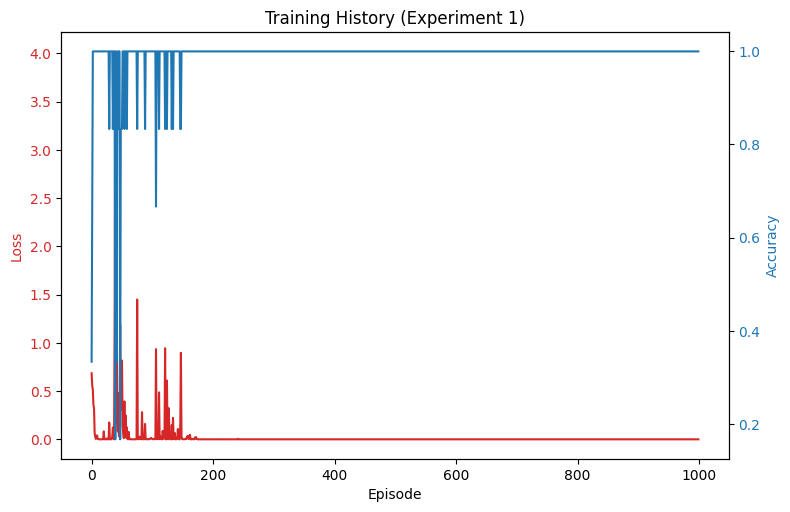

🚀 Starting Experiment 2 | LR=0.001, Embedding=128, Backbone=efficientnet
Loading pretrained weights from ./model/efficientnet_coffee.pth
[Exp 2] Episode 0: Train Loss=0.685491, Train Acc=0.67
[Exp 2] Episode 100: Train Loss=0.000004, Train Acc=1.00
[Exp 2] Episode 200: Train Loss=0.000002, Train Acc=1.00
[Exp 2] Episode 300: Train Loss=0.000046, Train Acc=1.00
[Exp 2] Episode 400: Train Loss=0.000000, Train Acc=1.00
[Exp 2] Final Evaluation -> Val Loss=0.017889, Val Acc=0.99 | Test Loss=0.027935, Test Acc=0.99


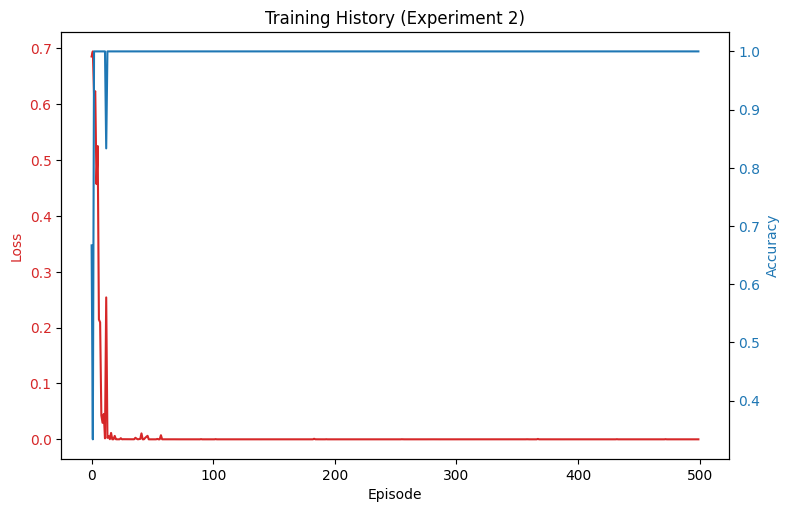

🚀 Starting Experiment 3 | LR=0.001, Embedding=128, Backbone=convnext
Loading pretrained weights from ./model/convnext_tiny_coffee.pth
[Exp 3] Episode 0: Train Loss=0.651971, Train Acc=1.00
[Exp 3] Episode 100: Train Loss=0.027772, Train Acc=1.00
[Exp 3] Episode 200: Train Loss=0.007946, Train Acc=1.00
[Exp 3] Episode 300: Train Loss=0.000003, Train Acc=1.00
[Exp 3] Episode 400: Train Loss=0.398872, Train Acc=0.83
[Exp 3] Final Evaluation -> Val Loss=1.684384, Val Acc=0.68 | Test Loss=3.061050, Test Acc=0.64


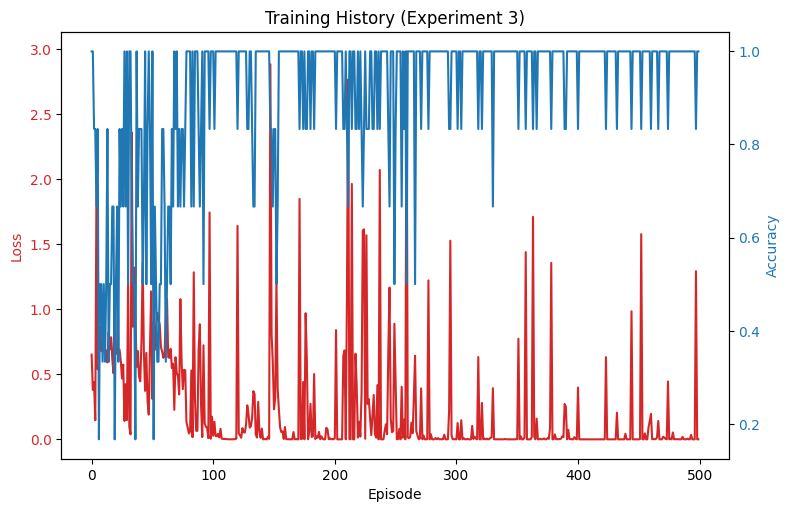

🚀 Starting Experiment 4 | LR=0.001, Embedding=128, Backbone=mobilenet
Loading pretrained weights from ./model/mobilenetv2_coffee.pth
[Exp 4] Episode 0: Train Loss=0.702845, Train Acc=0.33
[Exp 4] Episode 100: Train Loss=0.019888, Train Acc=1.00
[Exp 4] Episode 200: Train Loss=0.000009, Train Acc=1.00
[Exp 4] Episode 300: Train Loss=0.000008, Train Acc=1.00
[Exp 4] Episode 400: Train Loss=0.000084, Train Acc=1.00
[Exp 4] Final Evaluation -> Val Loss=1.621328, Val Acc=0.87 | Test Loss=0.497561, Test Acc=0.92


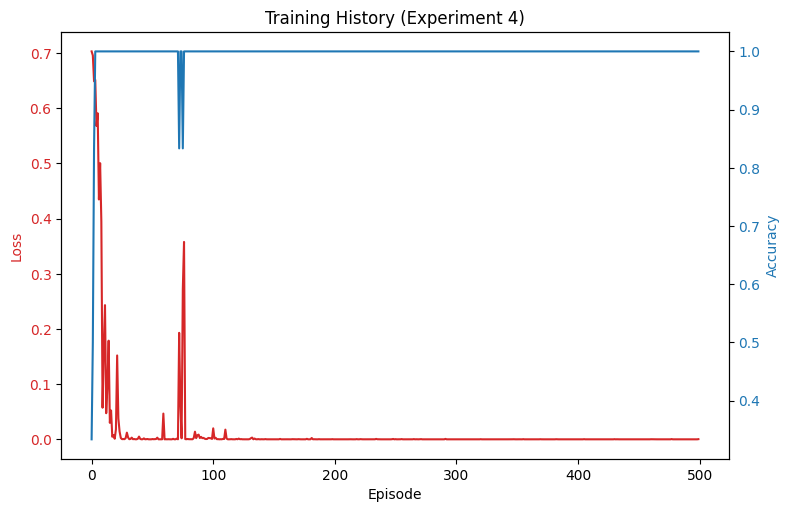

🚀 Starting Experiment 5 | LR=0.001, Embedding=128, Backbone=regnety
Loading pretrained weights from ./model/regnety_8gf_coffee.pth
[Exp 5] Episode 0: Train Loss=0.682072, Train Acc=0.67
[Exp 5] Episode 100: Train Loss=0.000051, Train Acc=1.00
[Exp 5] Episode 200: Train Loss=0.000000, Train Acc=1.00
[Exp 5] Episode 300: Train Loss=0.000018, Train Acc=1.00
[Exp 5] Episode 400: Train Loss=0.000048, Train Acc=1.00
[Exp 5] Final Evaluation -> Val Loss=0.070348, Val Acc=0.98 | Test Loss=0.116322, Test Acc=0.96


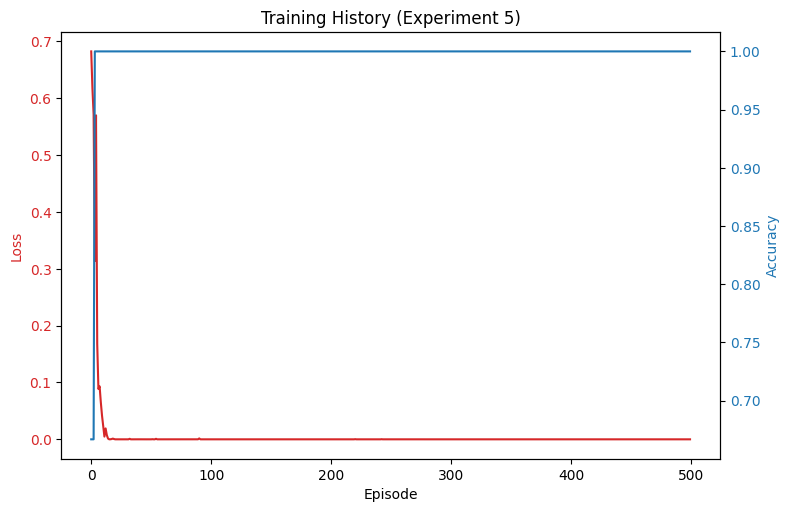

✅ All experiments completed! Results saved in 'results.csv'.


In [116]:
csv_filename = "results.csv"
if not os.path.exists(csv_filename):
    pd.DataFrame(columns=["Experiment", "Episode", "Phase", "Loss", "Accuracy"]).to_csv(csv_filename, index=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For each experiment configuration in your experiments list
for exp_num, exp in enumerate(experiments):
    print(f"🚀 Starting Experiment {exp_num+1} | LR={exp['lr']}, Embedding={exp['embedding_dim']}, Backbone={exp['backbone']}")
    
    # Initialize model with chosen backbone, embedding dimension and load pretrained weights if provided.
    model = ProtoNet(
        backbone=exp["backbone"],
        embedding_dim=exp["embedding_dim"],
        pretrained_path=exp["pretrained_path"]
    ).to(device)
    
    # Use weight decay to help regularization
    optimizer = optim.Adam(model.parameters(), lr=exp["lr"], weight_decay=1e-4)
    # Decay learning rate every 100 episodes by a factor of 0.9
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
    
    num_episodes = exp["num_episodes"]
    history = []   # For storing training metrics
    results = []   # For CSV logging
    
    # Get a training iterator from your few-shot dataloader
    train_iterator = iter(fewshot_dataloader)
    
    model.train()
    for episode in range(num_episodes):
        # Get the next training episode
        try:
            support_images, support_labels, query_images, query_labels = next(train_iterator)
        except StopIteration:
            train_iterator = iter(fewshot_dataloader)
            support_images, support_labels, query_images, query_labels = next(train_iterator)
        
        # Remove extra batch dimension (each batch is a task)
        support_images = support_images.squeeze(0).to(device)
        support_labels = support_labels.squeeze(0).to(device)
        query_images   = query_images.squeeze(0).to(device)
        query_labels   = query_labels.squeeze(0).to(device)
        
        # Compute prototypes and query predictions
        prototypes = compute_prototypes(support_images, support_labels, model)
        predictions = classify_query(prototypes, query_images, model)
        
        # Compute cross-entropy loss on query set
        loss = F.cross_entropy(predictions, query_labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate
        
        # Calculate training accuracy
        predicted_classes = torch.argmax(predictions, dim=1)
        acc = (predicted_classes == query_labels).float().mean().item()
        
        history.append({"Episode": episode, "Loss": loss.item(), "Accuracy": acc})
        
        # Optionally, log progress every 100 episodes
        if episode % 100 == 0:
            print(f"[Exp {exp_num+1}] Episode {episode}: Train Loss={loss.item():.6f}, Train Acc={acc:.2f}")
            results.append({
                "Experiment": exp_num+1,
                "Episode": episode,
                "Phase": "Train",
                "Loss": loss.item(),
                "Accuracy": acc
            })
    
    model.eval()
    val_loss, val_acc = evaluate(model, val_dataloader, device)
    test_loss, test_acc = evaluate(model, test_dataloader, device)
    
    results.append({
        "Experiment": exp_num+1,
        "Episode": num_episodes,
        "Phase": "Val",
        "Loss": val_loss,
        "Accuracy": val_acc
    })
    results.append({
        "Experiment": exp_num+1,
        "Episode": num_episodes,
        "Phase": "Test",
        "Loss": test_loss,
        "Accuracy": test_acc
    })
    
    print(f"[Exp {exp_num+1}] Final Evaluation -> Val Loss={val_loss:.6f}, Val Acc={val_acc:.2f} | Test Loss={test_loss:.6f}, Test Acc={test_acc:.2f}")
    
    # Save experiment results to CSV
    df = pd.DataFrame(results)
    df.to_csv(csv_filename, mode="a", header=False, index=False)
    
    # Plot training history for this experiment
    plot_training_history(history, exp_num+1)

print("✅ All experiments completed! Results saved in 'results.csv'.")